In [83]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py
#%matplotlib widget, remove below if used
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [84]:
def prepare_profile_data(files,spin_data_structure="New"):
    # spin data structure changed to two spin readouts therefore spin_data -> spin_data[0]
    # prepare the data into a data frame using the calibration Akio has performed
    df = pd.DataFrame()
    spin_list = [] # a list for the spin_sum
    qsum_list = [] # a list for the quad_sum 
    cant_pos_list_x, cant_pos_list_y, cant_pos_list_z = [[] for  x in range(3)] # save the positions of the cantielever
    if(spin_data_structure=="New"):spin_length = files[0].spin_data[0]
    if(spin_data_structure=="Old"):spin_length = files[0].spin_data
    spin_down_size_factor = len(spin_length)/len(files[0].xyz[0]) # 10 for normal operation, but can be different
    
    for i in tqdm(range(len(files))):
        spin = np.zeros(len(files[0].xyz[0]))
        if(spin_data_structure=="New"): spin_temp = files[i].spin_data[0]
        if(spin_data_structure=="Old"): spin_temp = files[i].spin_data
        for j in range(len(files[i].xyz[0])):
            spin[j]=np.average(spin_temp[int(spin_down_size_factor)*j: int(spin_down_size_factor)*j+ int(spin_down_size_factor-1)]) # average down to 5000 in order to match spin with the cantilever position.    
        spin_list.append(spin)
        qsum_list.append(files[i].quad_sum)
        cant_pos_list_x.append(files[i].cant_pos[0])
        cant_pos_list_y.append(files[i].cant_pos[1])
        cant_pos_list_z.append(files[i].cant_pos[2])
    df["QPD_SUM"] = qsum_list
    df["SPIN_SUM"] = spin_list 
    df["CANT_POS_X"] = cant_pos_list_x
    df["CANT_POS_Y"] = cant_pos_list_y
    df["CANT_POS_Z"] = cant_pos_list_z
    df["CANT_FREQ"] = files[0].cant_freq
    df["FS"] = files[0].fsamp
    
    # use calibration
    ## applies calibration assuming x and y have the same
    df["CANT_POS_X_cal"] = df["CANT_POS_X"].apply(lambda element: voltage_to_x_position(element))  
    df["CANT_POS_Y_cal"] = df["CANT_POS_Y"].apply(lambda element: voltage_to_x_position(element)) 
    df["CANT_POS_Z_cal"] = df["CANT_POS_Z"].apply(lambda element: voltage_to_z_position(element))
    
    
    # differentiate the power to get dP/dx plots
    df["QPD_SUM_diff"] = df["QPD_SUM"].apply(lambda element: np.diff(element)) # 
    df["SPIN_SUM_diff"] = df["SPIN_SUM"].apply(lambda element: np.diff(element)) # 
    
    return df

In [85]:
def extract_in_out_movement(df,fn,detector="SPIN",axis="Y",avg_rng=1):
    freq=np.mean(df.CANT_FREQ)
    fs=np.mean(df.FS)
    factor = int(fs/(2*freq))
    start = int(factor/2)
    #print(start)
    end= len(df["%s_SUM_diff" %detector][fn])-start
    #print(end)
    data_x = np.zeros(factor)
    data_x2 = np.zeros(factor)
    data_y = np.zeros(factor)
    data_y2 = np.zeros(factor)
    i=0
    for k in np.arange(start,end,factor):
        i+=1
        averaged_series = pd.Series(df["%s_SUM_diff" %detector][fn]).ewm(span=avg_rng,adjust=True).mean()
        data_y_temp = averaged_series[k:k+factor]/averaged_series.mean()#df["QPD_SUM_diff"][0][1300:-1400] # give y data 
        data_x_temp = df["CANT_POS_%s_cal" %axis][fn][k:k+factor]# give x data
        if(np.sum(data_y_temp)<0): data_y_temp = -data_y_temp
        if((i % 2) == 0):
            data_y = np.add(data_y,np.array(data_y_temp))
            data_x = np.add(data_x,data_x_temp)
        else:
            data_y2 = np.add(data_y2,np.array(data_y_temp))  
            data_x2 = np.add(data_x2,data_x_temp)
    data_x = data_x/(0.5*(i-1)) # factor automatic
    data_x2 = data_x2/(0.5*(i+1)) # factor automatic +-1
    data_y = data_y
    data_y2 = data_y2
    #plt.plot(data_x,data_y)
    return data_y,data_y2,data_x,data_x2        

In [86]:
def fit_dP_dx(data_x,data_y,data_y_error=None,plot=False,logscale=False):
    if(data_y_error==None): data_y_error = np.sqrt(np.abs(data_y)) # give y uncertainty
    def chisquare_gaussian_beam(area,mean,sigma,constant):
        return chisquare_1d(function=gaussian_beam,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
    arg_maxy = np.array(data_x)[np.argmax(np.array(data_y))]
    #print(maxy,np.sum(data_y))
    #plt.plot(data_x,data_y)
    #plt.show()
    try:
        m=Minuit(chisquare_gaussian_beam, 
                 area = np.max(data_y), # set start parameter
                 #limit_area= (np.sum(data_y)/200,np.sum(data_y)), # if you want to limit things
                 #fix_area = "False", # you can also fix it
                 mean = arg_maxy,
                 #fix_mean = "True",
                 limit_mean = (arg_maxy-20, arg_maxy+20),
                 sigma = 3.8,
                 #limit_sigma=(1,4),
                 #fix_sigma="True",
                 constant = 0,
                 fix_constant="True",
                 errordef = 1,
                 print_level=0,
                 pedantic=False)
        #print('Now proceed with the fit.')
        m.migrad()
        #print()
        #m.minos()#, if you need fancy mapping
        chisquare=m.fval
    except:print("Fit did not converge")   
    #print(chisquare)
    #print(m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"])
    if(plot==True):
        plt.plot(data_x,data_y)
        plt.plot(data_x,gaussian_beam(data_x,params=[m.values["area"],m.values["mean"],m.values["sigma"],m.values["constant"]]))
        if(logscale==True):plt.yscale("log")
        plt.show()
    return m

In [87]:
def extract_waist_data(df,up_or_low = "up",axis="Y",detector="SPIN",avg_rng=10,sub_sample=False,plot=False,logscale=True,save=True):
    sigma_list,sigma_err_list,mean_list,chi2_list,fit_list = [[] for x in range(5)]
    if(sub_sample==True):length=10
    else: length=len(df)
    for j in tqdm(np.arange(0,length,1)):
        data_y,data_y2,data_x,data_x2 = extract_in_out_movement(df,j,detector,axis,avg_rng=1)
        if(up_or_low=="up"):m = fit_dP_dx(data_x,data_y,plot=plot)
        if(up_or_low=="low"):m = fit_dP_dx(data_x2,data_y2,plot=plot)
        sigma_list.append(m.values["sigma"])
        sigma_err_list.append(m.errors["sigma"])
        mean_list.append(m.values["mean"])
        chi2_list.append(m.fval/(len(data_x)-3))
        fit_list.append(m)
    if(save==True):
        if(axis=="X"):fname=fname_x
        if(axis=="Y"):fname=fname_y
        np.save(folder+fname+"_sigma_list.npy", sigma_list)
        np.save(folder+fname+"_mean_list.npy", mean_list)
        np.save(folder+fname+"_chi2_list.npy", chi2_list)
    print(np.sum(data_y),m.values["area"],m.values["mean"],m.values["sigma"])
    return sigma_list,sigma_err_list, mean_list, chi2_list,fit_list

In [88]:
def make_x_axis_for_beam_profile(df):
    # reads in the z-position of each data set and provides an x_axis for the plots
    x_axis = []
    for i in range(len(df)):
        x_axis.append(df["CANT_POS_Z_cal"][i].mean())
    return x_axis

In [113]:
# step 1 load the data for x and y
Year = "2020"
Month = "10"
Day = "27"
BeadNumber = 1
#folder1 =  r"/home/data_transfer/data_from_windows/" +"ImageAnalysis/PositionCalibration/"+ Year + Month + Day + "/BeamProfile/"
#folder =  r"/home/data_transfer/data_from_windows/" +"ImageAnalysis/PositionCalibration/"+ Year + Month + Day +  "/BeamProfile/"
folder =  r"/home/data_transfer/data_from_windows/" + Year + Month + Day +  "/NoBead/"
print(folder)
#folder = r"/home/data_transfer/data_from_windows/20200930/NoBead/y210/"

fname_x="BeamProfile_X_Y350_0"
fname_y="BeamProfile_X_Y150_0"

#files_x = load_dir(folder, file_prefix = fname_x, max_file=100)
files_y = load_dir(folder, file_prefix = fname_y, max_file=100)

  1%|          | 1/99 [00:00<00:17,  5.76it/s]

/home/data_transfer/data_from_windows/20201027/NoBead/


100%|██████████| 99/99 [00:18<00:00,  4.89it/s]

99  files in folder
99  files loaded


In [114]:
# step 2 prepare the data into data frames, differentiate the signal and apply calibration

#df_x = prepare_profile_data(files_x)
df_y = prepare_profile_data(files_y)

100%|██████████| 99/99 [00:34<00:00,  2.85it/s]


In [139]:
#x_width_spin,x_width_spin_err,x_mean_spin,x_chi2_spin,x_fits_spin = extract_waist_data(df_x,up_or_low="low",axis="X",detector="SPIN",avg_rng=1,sub_sample=False,plot=False,logscale=False,save=False)
x_width_spin,x_width_spin_err,x_mean_spin,x_chi2_spin,x_fits_spin = extract_waist_data(df_x,up_or_low="up",axis="X",detector="SPIN",avg_rng=1,sub_sample=False,plot=False,logscale=False,save=False)


100%|██████████| 100/100 [01:03<00:00,  1.59it/s]

569572305.556269 25978410.045913097 386.8608937063242 5.322985824250229


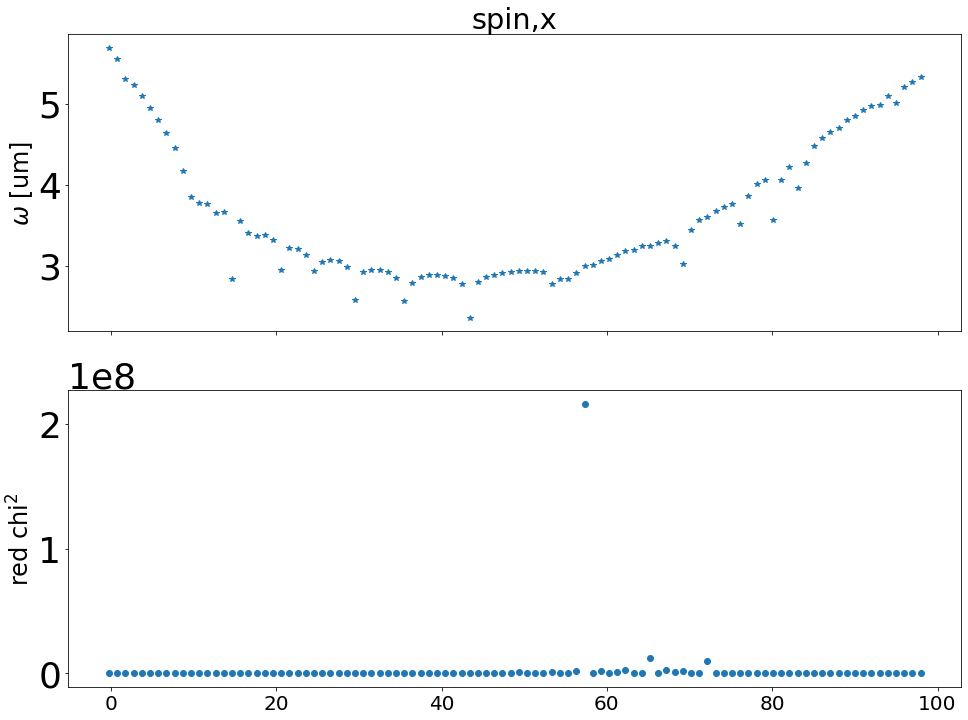

In [140]:
#x=np.arange(0,len(files_x),1)
x = make_x_axis_for_beam_profile(df_x)
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.set_title("spin,x")
ax1.errorbar(x, x_width_spin,x_width_spin_err,linestyle="",marker="*")
ax1.set_ylabel("$\omega$ [um]")
ax2.scatter(x, x_chi2_spin)
ax2.set_ylabel("red chi$^2$")
plt.show()



In [141]:
x_width_spin_l,x_width_spin_err_l,x_mean_spin_l,x_chi2_spin_l,x_fits_spin_l = extract_waist_data(df_x,up_or_low="low",axis="X",detector="SPIN",avg_rng=1,sub_sample=False,plot=False,logscale=False,save=False)
x_width_spin_u,x_width_spin_err_u,x_mean_spin_u,x_chi2_spin_u,x_fits_spin_u = extract_waist_data(df_x,up_or_low="up",axis="X",detector="SPIN",avg_rng=1,sub_sample=False,plot=False,logscale=False,save=False)


  0%|          | 0/100 [00:00<?, ?it/s]

569572305.556269 26917475.690013535 388.25997115567174 5.254318263024149



100%|██████████| 100/100 [01:03<00:00,  1.57it/s]

569572305.556269 25978410.045913097 386.8608937063242 5.322985824250229


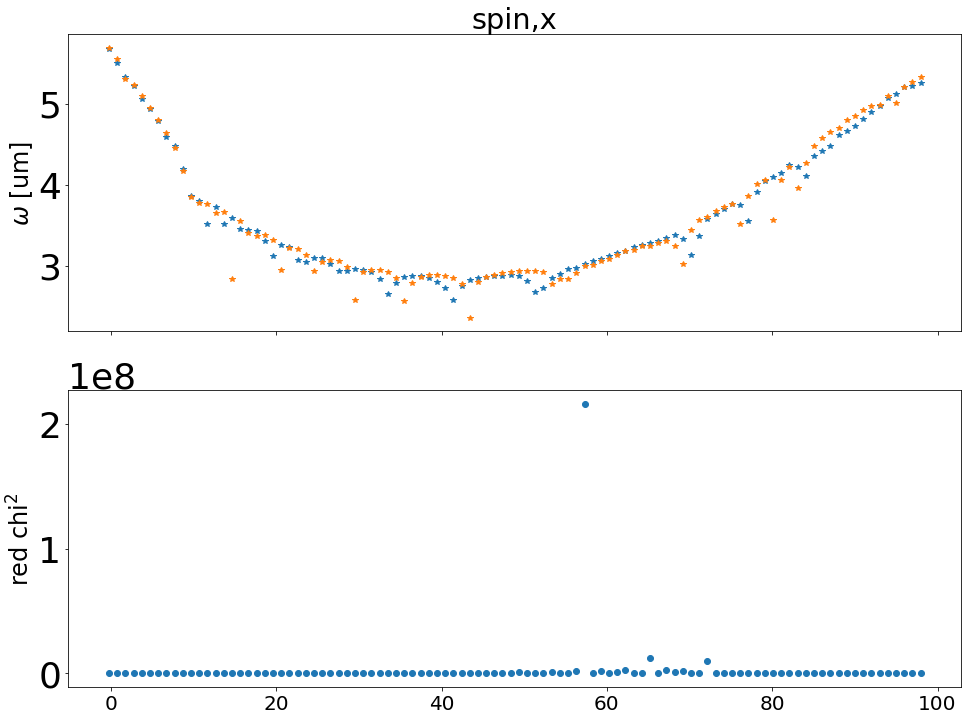

In [142]:
#x=np.arange(0,len(files_x),1)
x = make_x_axis_for_beam_profile(df_x)
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.set_title("spin,x")
ax1.errorbar(x, x_width_spin_l,x_width_spin_err_l,linestyle="",marker="*")
ax1.errorbar(x, x_width_spin_u,x_width_spin_err_u,linestyle="",marker="*")

ax1.set_ylabel("$\omega$ [um]")
ax2.scatter(x, x_chi2_spin)
ax2.set_ylabel("red chi$^2$")
plt.show()



In [ ]:
### y_width_spin,y_width_spin_err,y_mean_spin,y_chi2_spin,y_fits_spin =extract_waist_data(df_y,up_or_low="low",axis="X",detector="SPIN",avg_rng=1,sub_sample=False,plot=False,logscale=False,save=False)
#y_width_spin,y_width_spin_err,y_mean_spin,y_chi2_spin,y_fits_spin =extract_waist_data(df_y,up_or_low="up",axis="X",detector="SPIN",avg_rng=1,sub_sample=False,plot=False,logscale=False,save=False)

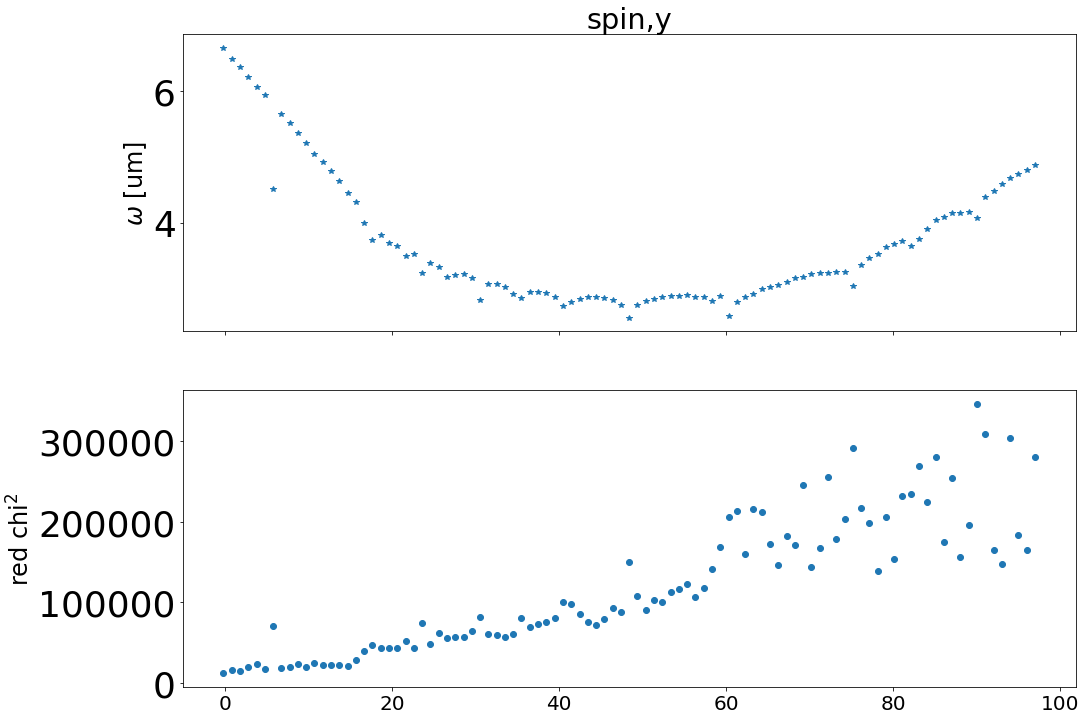

In [118]:
x = make_x_axis_for_beam_profile(df_y)
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.set_title("spin,y")
ax1.errorbar(x, y_width_spin,y_width_spin_err,linestyle="",marker="*")
ax1.set_ylabel("$\omega$ [um]")
ax2.scatter(x, y_chi2_spin)
ax2.set_ylabel("red chi$^2$")
plt.show()



In [119]:
x_width_qpd,x_width_qpd_err,x_mean_qpd,x_chi2_qpd,x_fits_qpd =  extract_waist_data(df_x,up_or_low="low",axis="X",detector="QPD",avg_rng=1,sub_sample=False,plot=False,logscale=False,save=False)

100%|██████████| 100/100 [01:03<00:00,  1.58it/s]

139399382.16158253 5979959.065414749 384.8062677178851 6.187579259554454


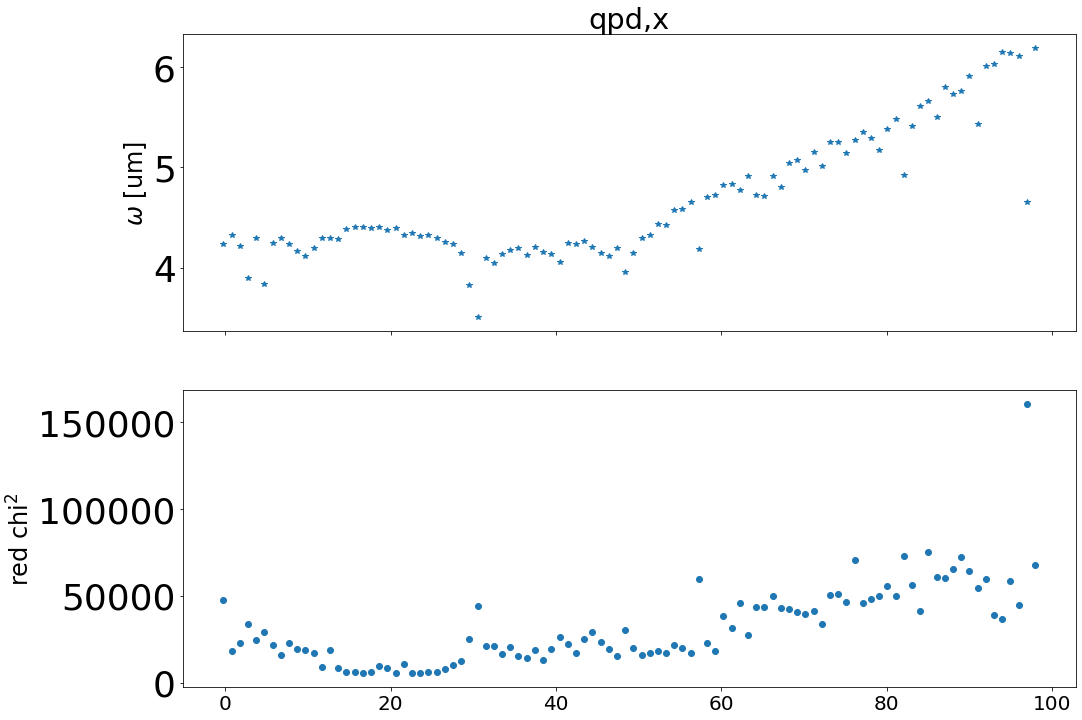

In [120]:
x = make_x_axis_for_beam_profile(df_x)
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.set_title("qpd,x")
ax1.errorbar(x, x_width_qpd,x_width_qpd_err,linestyle="",marker="*")
ax1.set_ylabel("$\omega$ [um]")
ax2.scatter(x, x_chi2_qpd)
ax2.set_ylabel("red chi$^2$")
plt.show()



In [121]:
#y_width_qpd,y_width_qpd_err,y_mean_qpd,y_chi2_qpd,x_fits_qpd =  extract_waist_data(df_y,up_or_low="low",axis="Y",detector="QPD",avg_rng=1,sub_sample=False,plot=False,logscale=False,save=False)
y_width_qpd,y_width_qpd_err,y_mean_qpd,y_chi2_qpd,x_fits_qpd =  extract_waist_data(df_y,up_or_low="low",axis="X",detector="QPD",avg_rng=5,sub_sample=False,plot=False,logscale=False,save=False)

100%|██████████| 99/99 [01:02<00:00,  1.58it/s]

69570405.243263 3125916.3724316927 383.8043236400264 5.8658076370680785


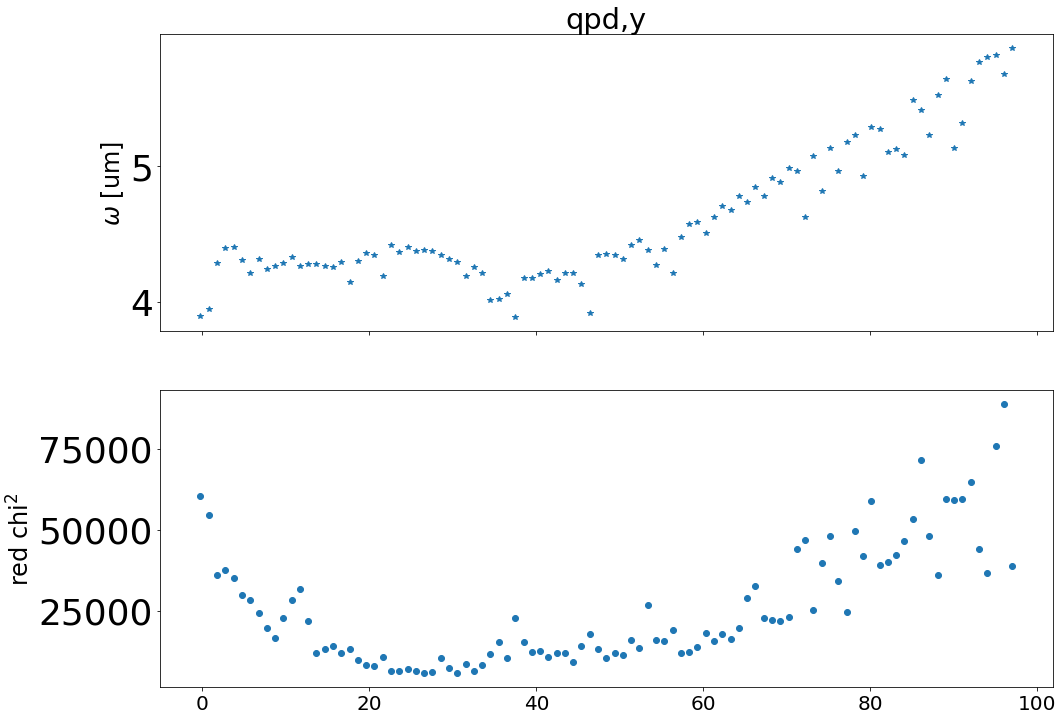

In [122]:
x = make_x_axis_for_beam_profile(df_y)
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.set_title("qpd,y")
ax1.errorbar(x, y_width_qpd,y_width_qpd_err,linestyle="",marker="*")
ax1.set_ylabel("$\omega$ [um]")
ax2.scatter(x, y_chi2_qpd)
ax2.set_ylabel("red chi$^2$")
plt.show()



In [123]:
data_list = [x_width_spin,y_width_spin,x_width_qpd,y_width_qpd]
error_list = [x_width_spin_err,y_width_spin_err,x_width_qpd_err,y_width_qpd_err]
name_list = ["spin,x","spin,y","qpd,x","qpd,y"]
omega_list = []
focus_list = []

def beam_width(x,params=list,wave_length=1.064):
    #defines the beam width using 1064 nm laser
    return params[0]*np.sqrt(1+((x-params[1])/(np.pi*params[0]*params[0]/wave_length))**2)

#def beam_width(x,params=list,wave_length=1.064):
#    # akio
#    return params[0]*np.sqrt(1+1.064*1.064*(x-params[1])*(x-params[1])/(np.pi*np.pi*params[0]*params[0]*params[0]*params[0]))


i=0
for data in data_list:
    i+=1
    def chisquare_beam_width(z,w):
        return chisquare_1d(function=beam_width,functionparams=[w,z],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]

    if(i==1 or i==3):data_x = np.asarray(make_x_axis_for_beam_profile(df_x))#np.arange(0,len(data),1)
    if(i==2 or i==4):data_x = np.asarray(make_x_axis_for_beam_profile(df_y))#np.arange(0,len(data),1)
    data_x = data_x
    data_y = data
    data_y_error = error_list[i-1]

    #least_squares = LeastSquares(data_x, data_y, data_y_error, beam_width)
    m = Minuit(chisquare_beam_width, z=50, w=5,pedantic=False)  # we need starting values for a and b
    
    m.migrad(ncall=50000) # finds minimum of least_squares function
    print("The fit parameters for %s are determined as:" %name_list[i-1])
    for p in m.parameters:
        print("{} = {:.3f} +/- {:.3f}".format(p, m.values[p], m.errors[p]))
    print("The reduced chi2 is at: %d"  %(m.fval/(len(data)-2)))    
    omega_list.append(m.values["w"])
    focus_list.append(m.values["z"])




The fit parameters for spin,x are determined as:
z = 51.929 +/- 0.000
w = 2.949 +/- 0.000
The reduced chi2 is at: 27285096
The fit parameters for spin,y are determined as:
z = 54.965 +/- 0.000
w = 2.993 +/- 0.000
The reduced chi2 is at: 15693200
The fit parameters for qpd,x are determined as:
z = 35.112 +/- 0.001
w = 4.034 +/- 0.000
The reduced chi2 is at: 1185691
The fit parameters for qpd,y are determined as:
z = 36.750 +/- 0.001
w = 4.043 +/- 0.000
The reduced chi2 is at: 852368


In [124]:
%%capture cap   

for p in m.parameters:
    print("{} = {:.3f} +/- {:.3f}".format(p, m.values[p], m.errors[p]))
print("The reduced chi2 is at: %d"  %(m.fval/(len(data)-2)))    
omega_list.append(m.values["w"])
focus_list.append(m.values["z"])

with open(folder1+fname_x+"_" + fname_y +'_waist_fit_parameters.txt', 'w') as out:
    out.write(cap.stdout)

NameError: name 'folder1' is not defined

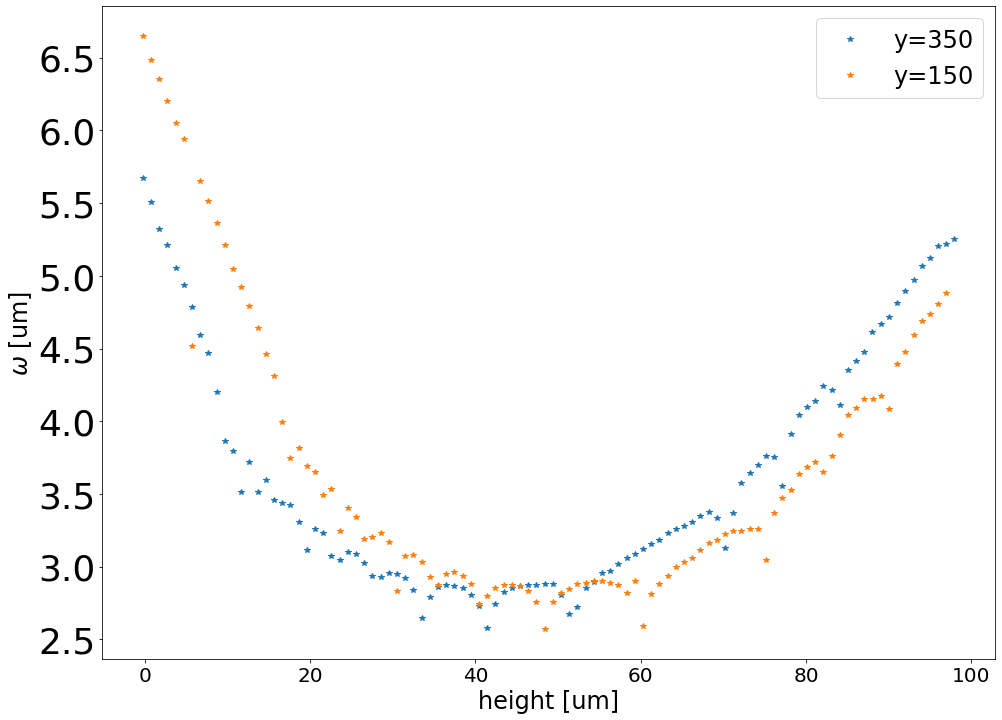

In [136]:
x_for_x = np.asarray(make_x_axis_for_beam_profile(df_x))
x_for_y =np.asarray(make_x_axis_for_beam_profile(df_y))
plt.plot(x_for_x, x_width_spin,linestyle="",marker="*",label="y=350")
plt.plot(x_for_y, y_width_spin,linestyle="",marker="*",label="y=150")
plt.ylabel("$\omega$ [um]")
plt.xlabel("height [um]")
plt.legend()
plt.show()

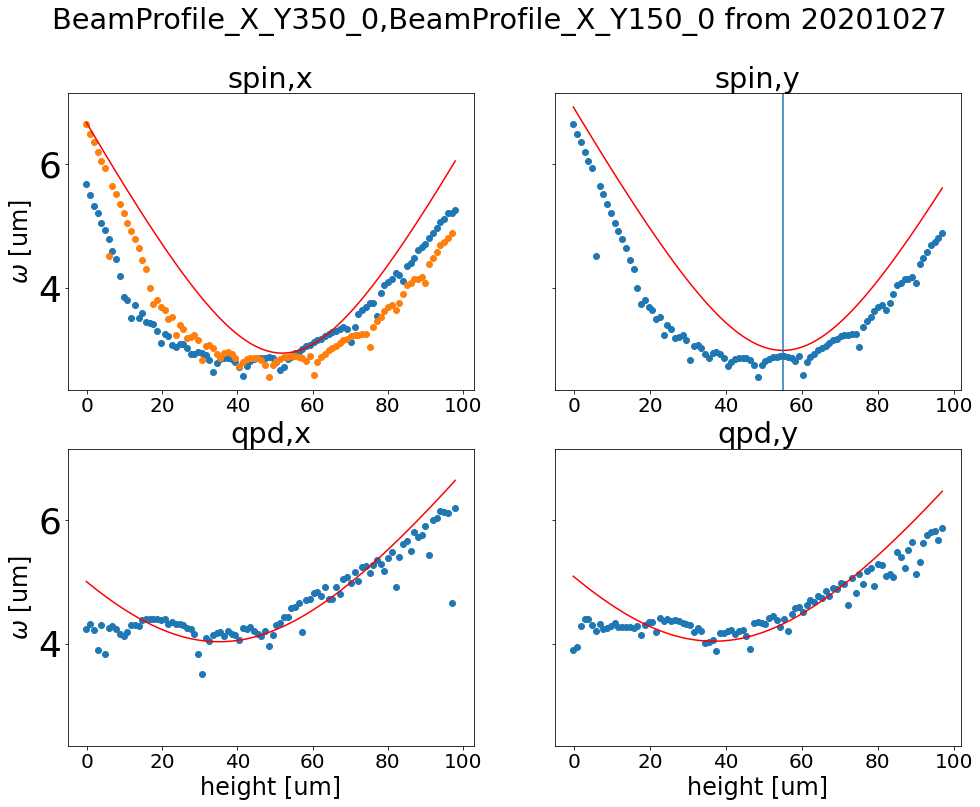

In [131]:
date=  Year + Month + Day  
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,sharey=True)
fig.suptitle("%s,%s from %s" %(fname_x,fname_y,date))

x_for_x = np.asarray(make_x_axis_for_beam_profile(df_x))
x_for_y =np.asarray(make_x_axis_for_beam_profile(df_y))

ax1.set_title("spin,x")
ax1.scatter(x_for_x, x_width_spin)
ax1.scatter(x_for_y, y_width_spin)

ax1.plot(x_for_x, beam_width(x_for_x,[omega_list[0],focus_list[0]]),color="red")

#ax1.axvline(focus_list[0])

ax1.set_ylabel("$\omega$ [um]")

ax2.set_title("spin,y")
ax2.scatter(x_for_y, y_width_spin)
ax2.plot(x_for_y, beam_width(x_for_y,[omega_list[1],focus_list[1]]),color="red")
ax2.axvline(focus_list[1])


ax3.set_title("qpd,x")
ax3.scatter(x_for_x, x_width_qpd)
ax3.set_ylabel("$\omega$ [um]")
ax3.plot(x_for_x, beam_width(x_for_x,[omega_list[2],focus_list[2]]),color="red")
ax3.set_xlabel("height [um]")


ax4.set_title("qpd,y")
ax4.scatter(x_for_y, y_width_qpd)
ax4.plot(x_for_y, beam_width(x_for_y,[omega_list[3],focus_list[3]]),color="red")
ax4.set_xlabel("height [um]")

plt.savefig(folder+""+fname_x+"_"+fname_y+"_waist_fit.png",dpi=300)
plt.show()

385.93715306098164


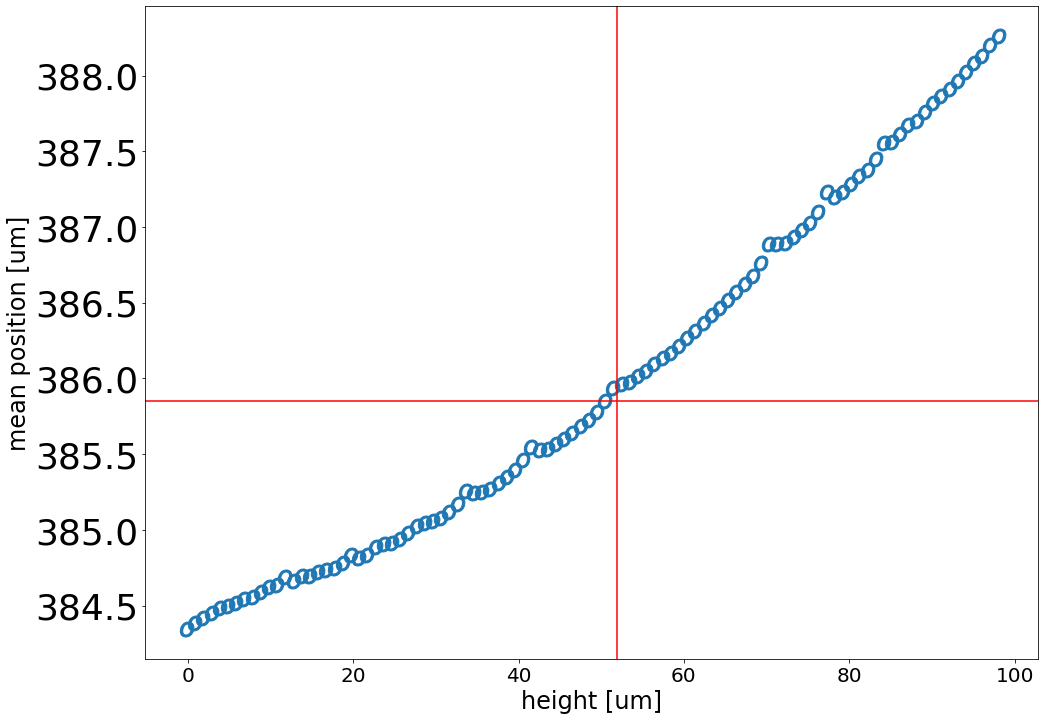

In [126]:
plt.plot(x_for_x,x_mean_spin,linestyle="",marker="$o$",markersize=15)
plt.ylabel("mean position [um]")
plt.xlabel("height [um]")
plt.axvline(focus_list[0],color="red")
plt.axhline(x_mean_spin[int(focus_list[0])],color="red")
print(x_mean_spin[1+int(focus_list[0])])
plt.show()

384.99996022924705


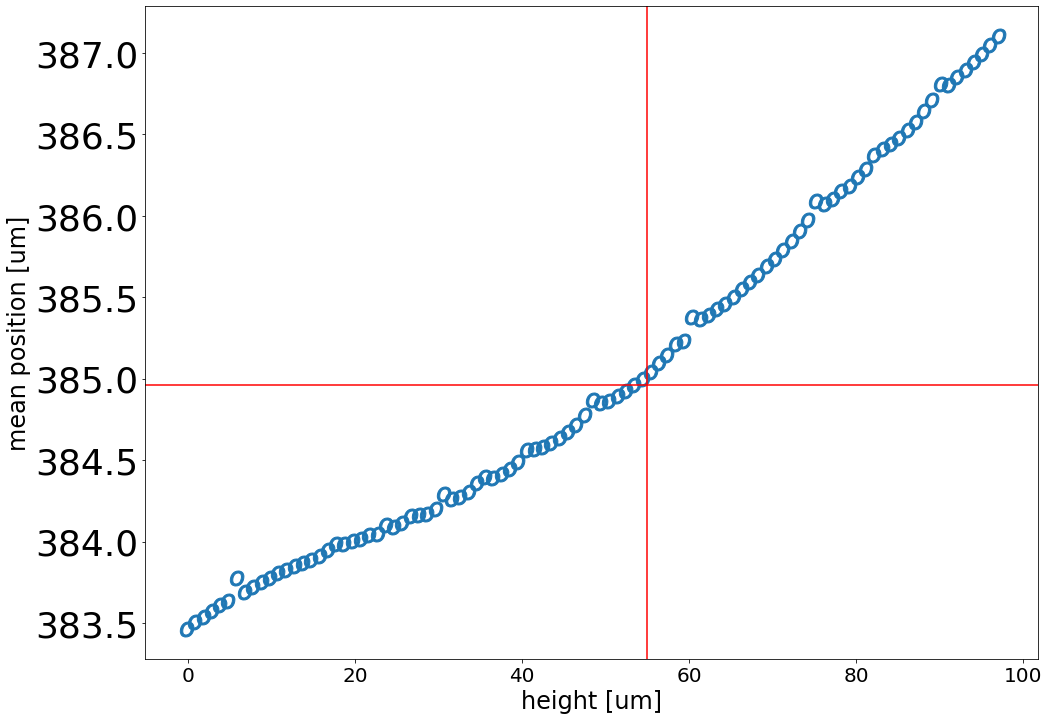

In [127]:
plt.plot(x_for_y,y_mean_spin,linestyle="",marker="$o$",markersize=15)
plt.ylabel("mean position [um]")
plt.xlabel("height [um]")
plt.axvline(focus_list[1],color="red")
plt.axhline(y_mean_spin[int(focus_list[1])],color="red")
print(y_mean_spin[1+int(focus_list[1])])
plt.show()

382.51705743178763


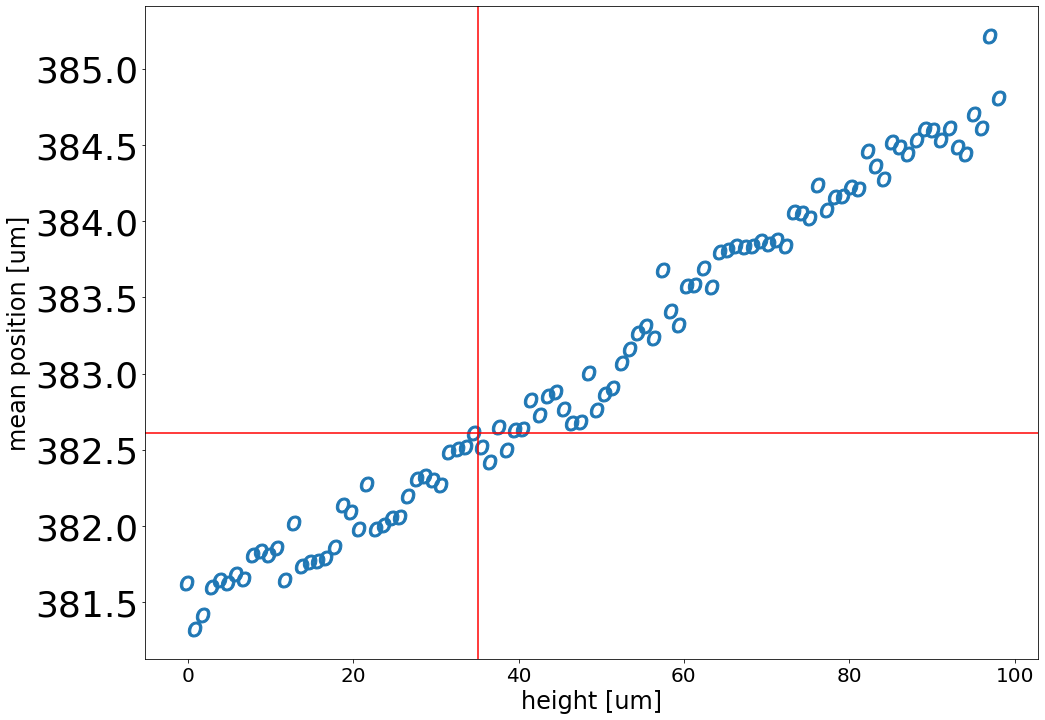

In [128]:
plt.plot(x_for_x,x_mean_qpd,linestyle="",marker="$o$",markersize=15)
plt.ylabel("mean position [um]")
plt.xlabel("height [um]")
plt.axvline(focus_list[2],color="red")
plt.axhline(x_mean_qpd[int(focus_list[2])],color="red")
print(x_mean_qpd[1+int(focus_list[2])])
plt.show()